# Physical Adversarial Attacks Against End-to-End Autoencoder Communication Systems
This note book is prepraed to accompany our paper titled "**Physical Adversarial Attacks Against End-to-End Autoencoder Communication Systems**" by **Meysam Sadeghi** and **Erik G. Larsson**. This code is provided as supplementary material to the aformentioned paper, to let the readers reproduce the results and also cultivate further research  on security and robustness of DL/ML in wireless communications.

The rest of the notebook is organized as follows:
1. Important Notes
2. Crafting White-box Adversarial Attacks (Fig. 2 of paper)
3. Crafting Shift Invariant Black-Box attacks (Fig. 3 of Paper)
4. Robustness of Autoencoders VS Classical Approaches (Fig. 4)
5. Conclusions and Future Works

## 1. Important Notes
### 1.1. Citing this notebook
If you use any part of this code, please consider citing our following works:

- M. Sadeghi and E. G. Larsson, "Physical Adversarial Attacks Against End-to-End Autoencoder Communication Systems," in IEEE Communications Letters. 

- M. Sadeghi and E. G. Larsson, “Adversarial attacks on deep-learning based radio signal classification,” IEEE Wireless Commun. Lett., vol. 8, no. 1, pp. 213–216, Feb. 2019.


If you have any questions, you can contact me via m.sadeghee@gmail.com.

<br>
<br>

### 1.2. On reproducibility
Consider our system set-up for reproducibility. We used TensorFlow version 1.8.0, and cudatoolkit 9.0.



### 1.3. On the Base Code for Autoencoders
Autoencoder communication systems where first proposed by Tim O'Shea and Jakob Hoydis in their paper titled "An Introduction to Deep Learning for the Physical Layer" \[3\]. Later Dr. Hoydis has released his code [HERE](https://colab.research.google.com/drive/1KLi10u-zUsdv1kQLAFcrRU0w0Gjd8QHN#scrollTo=Md3bzHC2UlB6). 

In order to provide a bench mark and enable a fair comparison, we use the same setting as the released code of \[3\], e.g., same deep network structure, same parameters, same modulation, $n=7$ and $k=4$, bpsk modulation, etc. Hence we use Dr. Jakob Hoydis's code as the base-line of our autoencoders and add the extra required methods or modules, e.g., to create adversarial attacks, jamming attacks, and hamming code with maximum likelihood detection, etc.


### 1.4. Considered Autoencoders
We consider the same autoencoder as those used in the paper (the MLP and CNN autoencoders). The structure of these two autoencoders (MLP and CNN) is shown in Table. 1. 

   <img src="original_dnn.jpg" width="500" height="400">
<center> Table.1 - The considered NN structures </center>

## 2. Crafting White-box Adversarial Attacks (Fig. 2 of paper)
In this section we show how one can create a white-box adversarial attack against an end-to-end autoencoder system. We implement the autoencoder using TensorFlow.

### 2.1.  Import required modules
Lets import the required modules, and initialize the parameters. We will consider a $n=7$ and $k=4$ autoencoder similar to \[3\]

In [1]:
import matplotlib.pyplot as plt   
import numpy as np
import tensorflow as tf
import time
import copy

k = 4
n = 7
seed = 0

### 2.2. Create an Autoencoder based Communication System
Now we need to create an autoencoder class. We use the MLP autoencoder of Table 1. Below we load it as a class.

In [2]:
from All_Autoencoder_Classes import AE_MLP

Now let us build an instance of the MLP autoencoder and then train it. For training we use $E_b / N_0 = 8.5$ dB.

In [3]:
# Training the MLP autoencoder
train_EbNodB =  8.5 
val_EbNodB = train_EbNodB
training_params = [
    #batch_size, lr,   ebnodb,      iterations
    [1000    , 0.001,  train_EbNodB, 1000],
    [1000    , 0.0001, train_EbNodB, 10000],
    [10000   , 0.0001, train_EbNodB, 10000],
    [10000   , 0.00001, train_EbNodB, 10000]
]
validation_params = [
    #batch_size, ebnodb, val_steps 
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 1000],
    [100000, val_EbNodB, 1000],
    [100000, val_EbNodB, 1000]
]

# Create the Model
p = np.zeros([1,2,n]) # note that during training the attack must NOT be included
#
model_file_MLP = 'models_attacked_MLP/ae_k_{}_n_{}'.format(k,n)
ae_MLP = AE_MLP(k,n,seed)
ae_MLP.train(p,training_params, validation_params)
ae_MLP.save(model_file_MLP)


Batch Size: 1000, Learning Rate: 0.001, EbNodB: 8.5, Iterations: 1000
0.96717
0.20968997
0.0039200187
0.00015002489
0.00018000603
0.00014001131
0.00012999773
6.0021877e-05
2.9981136e-05
2.9981136e-05

Batch Size: 1000, Learning Rate: 0.0001, EbNodB: 8.5, Iterations: 10000
2.002716e-05
6.0021877e-05
2.002716e-05
6.997585e-05
1.001358e-05
2.9981136e-05
0.0
1.001358e-05
2.9981136e-05
1.001358e-05

Batch Size: 10000, Learning Rate: 0.0001, EbNodB: 8.5, Iterations: 10000
2.9981136e-05
2.002716e-05
0.0
2.9981136e-05
1.001358e-05
1.001358e-05
1.001358e-05
2.9981136e-05
2.002716e-05
0.0

Batch Size: 10000, Learning Rate: 1e-05, EbNodB: 8.5, Iterations: 10000
2.002716e-05
0.0
0.0
0.0
0.0
0.0
2.9981136e-05
0.0
1.001358e-05
0.0


'models_attacked_MLP/ae_k_4_n_7'

### 2.3. Create White-Box Adversarial Attack
Now that we have a tarined model, we can check its performance, when there is not attack, and also under **adversarial attacks**. Also to provide a bench mark, we are interetested to compare it with the jamming attacks. So, first we create the adversarial perturbation, using **Alg. 1**, proposed in our paper.

In [4]:
model_file_MLP = 'models_attacked_MLP/ae_k_{}_n_{}'.format(k,n)
ae_MLP = AE_MLP(k,n,seed, filename=model_file_MLP) # Load the pretrained model we just saved
PSR_dB = -6
num_samples =  10
ebnodb = 0
universal_per_fgm_MLP = ae_MLP.UAPattack_fgm(ebnodb,num_samples,PSR_dB)

INFO:tensorflow:Restoring parameters from models_attacked_MLP/ae_k_4_n_7


### 2.4. Check the Performance of Autoencoder under Attack
Now we calculate the BLER for the three cases, 1) no attack, 2) adversarial attack, and 3) jamming attack. To present a better view we consider three different PSR values, PSR=-2 dB, -6 dB, and -10 dB. Note that PSR is defined as the ratio of the received perturbation power to the received signal power.

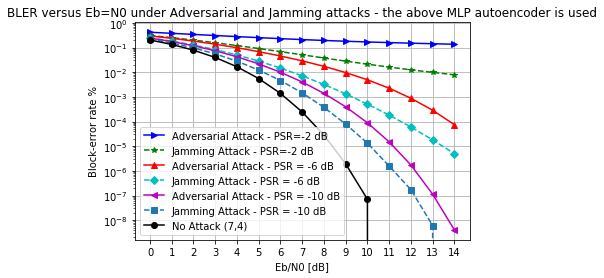

In [5]:
ebnodbs = np.linspace(0,14,15,dtype=int) 
batch_size = 1000000 
#
PSR_dB = -2
_ , BLER_Adv_Attack_minus2, BLER_Jamming_Attack_minus2 = ae_MLP.bler_sim_attack_AWGN(universal_per_fgm_MLP.reshape(1,2,n), PSR_dB, ebnodbs, batch_size, 300) #50
#
PSR_dB = -6
_, BLER_Adv_Attack_minus6, BLER_Jamming_Attack_minus6 = ae_MLP.bler_sim_attack_AWGN(universal_per_fgm_MLP.reshape(1,2,n), PSR_dB, ebnodbs, batch_size, 300) #100
#
PSR_dB = -10
BLER_No_Attack , BLER_Adv_Attack_minus10, BLER_Jamming_Attack_minus10 = ae_MLP.bler_sim_attack_AWGN(universal_per_fgm_MLP.reshape(1,2,n), PSR_dB, ebnodbs, batch_size, 500) # 300
#

fig, ax = plt.subplots()

ax.plot(ebnodbs,BLER_Adv_Attack_minus2,'b>-',label='Adversarial Attack - PSR=-2 dB')
ax.plot(ebnodbs,BLER_Jamming_Attack_minus2,'g*--',label='Jamming Attack - PSR=-2 dB')


ax.plot(ebnodbs,BLER_Adv_Attack_minus6,'r^-',label='Adversarial Attack - PSR = -6 dB')
ax.plot(ebnodbs,BLER_Jamming_Attack_minus6,'cD--',label='Jamming Attack - PSR = -6 dB')

ax.plot(ebnodbs,BLER_Adv_Attack_minus10,'m<-',label='Adversarial Attack - PSR = -10 dB')
ax.plot(ebnodbs,BLER_Jamming_Attack_minus10,'s--',label='Jamming Attack - PSR = -10 dB')

ax.plot(ebnodbs,BLER_No_Attack,'ko-',label='No Attack ({},{})'.format(n,k))

plt.title('BLER versus Eb=N0 under Adversarial and Jamming attacks - the above MLP autoencoder is used')
plt.yscale('log')
plt.legend(loc='lower left')
plt.xticks(ebnodbs,ebnodbs)
ax.set_xlabel('Eb/N0 [dB]')
ax.set_ylabel('Block-error rate %')
ax.grid(True)
plt.show()

## 3. Crafting Shift Invariant Black-Box attacks (Fig. 3 of Paper)
In previous section, we presented a white-box attack, i.e., we considered two restrictive assumptions in order to craft adversarial perturbations. First, we assumed that the adversarial attacker has perfect knowledge of the autoencoder system, including the number of layers, weight and bias parameters of the decoder block. Second, the attacker is synchronous with the transmitter.

Consider the CNN autoencoder of Table I, and assume an attacker is interested to create an adversarial attack for it, without having any knowledge about its structure or parameters. The transferability of adversarial attacks says that attacks designed for a specific model are also effective for other models, with high probability \[4\]. Therefore, the attacker can use its own substitute autoencoder communication system and then design a white-box attack for it, as it has the perfect knowledge of this substitute autoencoder communication system. Then use the
designed perturbation to attack the original unknown model. This attack is called a black-box adversarial attack \[5\]. 

In the following we show an example of black box attacks.

### 3.1. Load a UAP designed based on MLP of Table 1
Let us first load an adversarial perturbation that is designed following Algorithm 2 of the paper, where we used the MLP autoencoder of Table. 1. as the substitute network. In more details, the adversarial attacker would like to attack an unkonwnon network (here the CNN network of Table. 1). So, the adversary design an attack for a substitute network (the MLP of Table. 1) and then apply it on other unkonwn networks.


**Two important points:**


- It is important to note that the following adversarial perturbation we found, is just one possible perturbation out of infinitly many adversarial perturbation. Also, it is not the most destructive one. I am sure, using better algorithms or more computation power, one could find better attacks. But, even the current attack (which is not the most destructive), show the impact and effectiveness of adversarial attacks.
    
- Given the infinitely many adversarial perturbations, if a crafted perturbation can not be as destructive as we want, we always can search for more effective attacks.


In [6]:
import pickle 
with open('UAP','rb') as load_data:
    UAP = pickle.load(load_data)

### 3.2. Create the CNN autoencoder of Table 1 and Train it
Now let us import the CNN autoencoder of Table 1, as a class.

In [7]:
from All_Autoencoder_Classes import AE_CNN

Now we create an instance of the CNN autoencoder and train it.

In [8]:
# Training the CNN autoencoder
train_EbNodB =  8.5 
val_EbNodB = train_EbNodB
training_params = [
    #batch_size, lr, ebnodb, iterations
    [1000    , 0.001,  train_EbNodB, 1000],
    [1000    , 0.0001, train_EbNodB, 10000],
    [10000   , 0.0001, train_EbNodB, 10000],
    [10000   , 0.00001, train_EbNodB, 10000]
]
validation_params = [
    #batch_size, ebnodb, val_steps 
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 1000],
    [100000, val_EbNodB, 1000],
    [100000, val_EbNodB, 1000]
]

# Create the Model
p = np.zeros([1,2,n]) # note that during training the attack must NOT be included
#
model_file_CNN = 'models_attacked_CNN/ae_k_{}_n_{}'.format(k,n)
ae_CNN = AE_CNN(k,n,seed)
ae_CNN.train(True,0, p,training_params, validation_params)
ae_CNN.save(model_file_CNN)


Batch Size: 1000, Learning Rate: 0.001, EbNodB: 8.5, Iterations: 1000
0.88515997
0.00019997358
6.997585e-05
7.998943e-05
3.9994717e-05
2.9981136e-05
1.001358e-05
2.9981136e-05
2.002716e-05
2.9981136e-05

Batch Size: 1000, Learning Rate: 0.0001, EbNodB: 8.5, Iterations: 10000
3.9994717e-05
0.0
2.002716e-05
2.9981136e-05
2.002716e-05
2.9981136e-05
0.0
0.0
2.002716e-05
1.001358e-05

Batch Size: 10000, Learning Rate: 0.0001, EbNodB: 8.5, Iterations: 10000
3.9994717e-05
0.0
1.001358e-05
0.0
2.002716e-05
0.0
2.9981136e-05
1.001358e-05
1.001358e-05
1.001358e-05

Batch Size: 10000, Learning Rate: 1e-05, EbNodB: 8.5, Iterations: 10000
0.0
0.0
1.001358e-05
0.0
1.001358e-05
0.0
1.001358e-05
0.0
2.002716e-05
0.0


'models_attacked_CNN/ae_k_4_n_7'

### 3.3. Black-Box Attack Against the CNN Autoencoder
Then we attack the trained CNN autoencoder. We use three different PSR levels as shown in the paper.

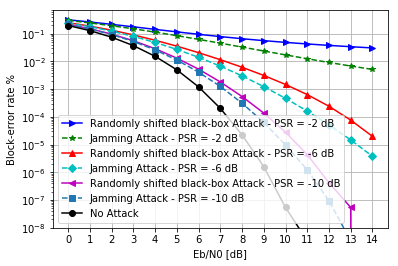

In [9]:
batch_size=1000000 # montcarlo
ebnodbs = np.linspace(0,14,15,dtype=int) 

PSR_dB= -2   
BLER_no_attack_uap_fgm2, BLER_attack_rolled_uap_fgm2, BLER_jamming1_uap_fgm2 = ae_CNN.bler_sim_attack_AWGN(False, 0, UAP.reshape(1,2,n), PSR_dB, ebnodbs, batch_size, 300) 

PSR_dB= -6  
BLER_no_attack_uap_fgm6, BLER_attack_rolled_uap_fgm6, BLER_jamming1_uap_fgm6 = ae_CNN.bler_sim_attack_AWGN(False, 0, UAP.reshape(1,2,n), PSR_dB, ebnodbs, batch_size, 300)

PSR_dB= -10   
BLER_no_attack_uap_fgm10, BLER_attack_rolled_uap_fgm10, BLER_jamming1_uap_fgm10 = ae_CNN.bler_sim_attack_AWGN(False, 0, UAP.reshape(1,2,n), PSR_dB, ebnodbs, batch_size, 300) # 500


# plot
fig, ax = plt.subplots()
ax.plot(ebnodbs,BLER_attack_rolled_uap_fgm2,'b>-',label='Randomly shifted black-box Attack - PSR = -2 dB')
ax.plot(ebnodbs,BLER_jamming1_uap_fgm2,'g*--',label='Jamming Attack - PSR = -2 dB')

ax.plot(ebnodbs,BLER_attack_rolled_uap_fgm6,'r^-',label='Randomly shifted black-box Attack - PSR = -6 dB')
ax.plot(ebnodbs,BLER_jamming1_uap_fgm6,'cD--',label='Jamming Attack - PSR = -6 dB')

ax.plot(ebnodbs,BLER_attack_rolled_uap_fgm10,'m<-',label='Randomly shifted black-box Attack - PSR = -10 dB')
ax.plot(ebnodbs,BLER_jamming1_uap_fgm10,'s--',label='Jamming Attack - PSR = -10 dB')

ax.plot(ebnodbs,BLER_no_attack_uap_fgm6,'ko-',label='No Attack')

plt.yscale('log')
plt.legend(loc='lower left')
plt.xticks(ebnodbs,ebnodbs)
plt.ylim(1e-8,0.7)
ax.set_xlabel('Eb/N0 [dB]')
ax.set_ylabel('Block-error rate %')
ax.grid(True)
plt.show()

## 4. Robustness of Autoencoders VS Classical Approaches (Fig. 4)
In this part we compare the robustnes of end-to-end autoencoders versus a classical approach. The considered classical approach is binary phase-shift keying (BPSK) modulation combined with a Hamming (7,4) code and maximum-likelihood decoding (MLD).

First, we imlement the classical approach and apply different atacks on it.

In [10]:
from hamming import hamming_74
num_blocks = 1000000
PSR_dB = -6 
BLER_HD, BLER_MLD, BLER_HD_adv, BLER_MLD_adv, BLER_HD_jam, BLER_MLD_jam = hamming_74(n, k, ebnodbs, num_blocks, UAP, PSR_dB)

Now we apply a balck-box attack on the CNN autoencoder of Table 1.

In [11]:
batch_size = 1000000 
iterations = 300
PSR_dB = -6 
BLER_no_attack_uap_fgm6, BLER_attack_rolled_uap_fgm6, BLER_jamming1_uap_fgm6 = ae_CNN.bler_sim_attack_AWGN(False, 0, UAP.reshape(1,2,n), PSR_dB, ebnodbs, batch_size, iterations)

Now we plot the results, as shown in Fig. 4 in the paper.

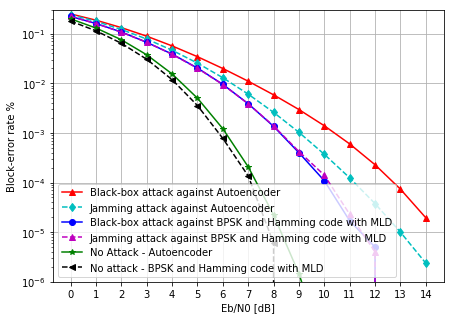

In [12]:
ebnodbs = np.linspace(0,14,15,dtype=int)  
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(ebnodbs,BLER_attack_rolled_uap_fgm6,'^r-',label='Black-box attack against Autoencoder')
ax.plot(ebnodbs,BLER_jamming1_uap_fgm6,'cd--',label='Jamming attack against Autoencoder')
ax.plot(ebnodbs, BLER_MLD_adv,'bo-',label='Black-box attack against BPSK and Hamming code with MLD')
ax.plot(ebnodbs, BLER_MLD_jam,'m--^',label='Jamming attack against BPSK and Hamming code with MLD')
ax.plot(ebnodbs,BLER_no_attack_uap_fgm6,'g*-',label='No Attack - Autoencoder')
ax.plot(ebnodbs, BLER_MLD,'k<--',label='No attack - BPSK and Hamming code with MLD')

plt.yscale('log')
plt.legend(loc='lower left')
plt.xticks(ebnodbs,ebnodbs)
plt.ylim((10**-6,0.3))
ax.set_xlabel('Eb/N0 [dB]')
ax.set_ylabel('Block-error rate %')
ax.grid(True)
plt.show()

## 5. Conclusions and Future Works  
As the application of DL/ML in communication systems is becoming more popular, it is important to think about these applications from a security and robustness perspective. In our works \[1, 2\], we tried to show that adversarial attacks are a new type of security threat for DL/ML based communication systems, which should be dealt with.

We also should note that although we tried to do as many simulations as possible and study as many different scenarios as we can, time and computational resources limited our studies. More importantly, we just have initiated a first step and there are plenty many directions that are required to be further investigated and studied. For example, our results in \[1\] were obtained for physical adversarial attacks in AWGN channels, considering AWGN jamming. For example, the extension to more advanced channel models, e.g., Rayleigh fading, is an interesting direction for future work, among many others. 

We hope that our initial results and the fact that we have released all our codes publiclly will stimulate future research on this topic and help us to improve our understanding on **the security and robustness of DL/ML for wireless communications**.

I hope the efforts I put on this has been useful to you and good luck with your research.

##  References
\[1\] M. Sadeghi and E. G. Larsson, "Physical Adversarial Attacks Against End-to-End Autoencoder Communication Systems," in IEEE Communications Letters.

\[2\] M. Sadeghi and E. G. Larsson, “Adversarial attacks on deep-learning based radio signal classification,” IEEE Wireless Commun. Lett., vol. 8, no. 1, pp. 213–216, Feb. 2019.

\[3\] T. O’Shea and J. Hoydis, “An introduction to deep learning for the physical layer,” IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563–575, Dec. 2017.

\[4\] N. Papernot, P. D. McDaniel, and I. J. Goodfellow, “Transferability in machine learning: from phenomena to black-box attacks using adversarial samples,” CoRR, vol. abs/1605.07277, 2016

\[5\] C. Szegedy, W. Zaremba, I. Sutskever, J. Bruna, D. Erhan, I. Goodfellow, and R. Fergus, “Intriguing properties of neural networks,” arXiv preprint arXiv:1312.6199, 2013.

\[6\] I. J. Goodfellow, J. Shlens, and C. Szegedy, “Explaining and harnessing adversarial examples,” arXiv preprint arXiv:1412.6572, 2014.